# `pyutils` multifile  

## Introduction 

This turorial is intended to show users how to handle multiple input files using `pyutils`, either using local file lists, remote file lists, and SAM definitions.

We will go through three different scenarios, where our primary tools we be `pyimport` and `pyprocess`. 

## Table of contents
1. Setup
1. `pyimport` with a list of local files 
1. `pyimport` with a SAM definition or list of remote files
2. Using `pyprocess` directly 


## 1. Setup

As in [pyutils_basics.ipynb](pyutils_basics.ipynb), we need to add `pyutils` to our Python path.

In [1]:
import sys 
sys.path.append("../../utils/pyutils")

## 2. `pyimport` with a list of local files 

The `import_dataset` function from `pyimport` can be used to import a list of local TTree (EventNtuple) files into a single concatenated array, where `pyimport` employs `pyprocess` to multithread each file operation. 

"Local" means that each file name includes the full path to a localtion on a local disk, such as `/exp/data`. 

In [2]:
# Import the Importer class from pyimport 
from pyimport import Importer 

# Initialise the Importer class instance
importer = Importer(
    verbosity = 2 
)

# Define path to list of 10 local files
file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt"

# Define branches
# Branches can also be defined as a list of a grouped dict of lists, depending on requirements
branches = [
    "event",
    "trk.nactive",
    "trkqual.result",
    "crvcoincs.PEs",
    "trksegs"
]

# Import the files using multithreading
data = importer.import_dataset(
    file_list_path = file_list_path, 
    branches = branches
)

[pyimport] Initialised Importer with path 'EventNtuple/ntuple' and verbosity=2
[pyprocess] Loading file list from /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt
[pyprocess] ✅  Successfully loaded file list
	Path: /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/local_file_list.txt
	Count: 10 files
[pyprocess] Starting processing on 10 files with 10 workers
[pyprocess] ✅  nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000332.root
	Progress: 1/10 files (10.0%)

[pyprocess] ✅  nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000812.root
	Progress: 2/10 files (20.0%)

[pyprocess] ✅  nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000579.root
	Progress: 3/10 files (30.0%)

[pyprocess] ✅  nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03_00.001210_00000343.root
	Progress: 4/10 files (40.0%)

[pyprocess] ✅  nts.mu2e.CeEndpointOnSpillTriggered.MDC2020aq_best_v1_3_v06_03

We now have a concatenated awkward array called `data` which can be used for analysis.

> **Note**: Be mindful of memory constraints with large datasets.

## 3. `pyimport` with a SAM definition or list of remote files

If the imported is initialised with `use_remote` flag set to true, you can pass a SAM definition or a list of remote files to `import_dataset`, which will return a concatenated awkward array. 

In [3]:
# Import the Importer class from pyimport 
from pyimport import Importer 

# Define our remote file list (10 files)
file_list_path = "/exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/remote_file_list.txt"

# Initialise the Importer class instance with use_remote 
# File locations are on persistent, so we need the location argument 
importer = Importer(
    use_remote = True, 
    location = "disk",
    verbosity = 2
)

# Define branches
# Branches can also be defined as a list of a grouped dict of lists, depending on requirements
branches = [
    "event",
    "trk.nactive",
    "trkqual.result",
    "crvcoincs.PEs",
    "trksegs"
]

# Import the files using multithreading
data = importer.import_dataset(
    file_list_path = file_list_path, # 
    # defname = defname, # can also pass a SAM defname! 
    branches = branches
)

[pyimport] Initialised Importer with path 'EventNtuple/ntuple' and verbosity=2
[pyprocess] Loading file list from /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/remote_file_list.txt
[pyprocess] ✅  Successfully loaded file list
	Path: /exp/mu2e/data/users/sgrant/EventNtuple/TestFileLists/remote_file_list.txt
	Count: 10 files
[pyprocess] Starting processing on 10 files with 10 workers
[pyprocess] ✅  nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00050440.root
	Progress: 1/10 files (10.0%)

[pyprocess] ✅  nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00000035.root
	Progress: 2/10 files (20.0%)

[pyprocess] ✅  nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00005260.root
	Progress: 3/10 files (30.0%)

[pyprocess] ✅  nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.001202_00075004.root
	Progress: 4/10 files (40.0%)

[pyprocess] ✅  nts.mu2e.Cos

We now have a concatenated awkward array called `data` which can be used for analysis.

> **Note**: Be mindful of memory constraints with large datasets.

## 4. Using `pyprocess` directly 

`pyprocess` provides a tool for generating file lists and for generic multithreading, which can provide more flexibility than `pyimport` by itself by allowing users to write their own process functions.

For example, we can tell each worker thread to fill a histogram which we will combine at the end. This method has the potential to be more memory efficient that what is currently available in `pyimport`. 

In [11]:
# Import external packages
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt 

# Import the Processor class from pyprocess 
from pyprocess import Processor  

# Initiliase the Processor 
processor = Processor(verbosity = 1) 

# Define a SAM definition (817 files)
defname = "nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root"

# Get our file list 
file_list = processor.get_file_list(defname=defname)

# Slice the file list to get the first 10 files, just for the sake of the example.
# In principle, this method should be far more memory efficient than returing arrays,
# and should work for the entire dataset 
file_list = file_list[:10]

# Define our branches 
# We just want the parameter we are filling the histogram with 
branches = [ "crvcoincs.PEs" ] 

# Define number of bins and range
nbins = 1000
xrange = (0, 10000)

# Define our process function which will be executed by each worker thread 
def process(file_name): 
    # Start an Importer instance 
    local_importer = Importer(
        use_remote=True,
        location="disk",
        verbosity=0
    )
    # Import the branches
    local_data = local_importer.import_file(
        file_name = file_name,
        branches = branches
    )
    # Flatten the data
    PEs = ak.flatten(local_data["crvcoincs.PEs"], axis=None)
    # Fill the histogram 
    counts, bin_edges = np.histogram(PEs, bins=nbins, range=xrange) 
    # Return the histogram
    return counts, bin_edges 
    
# Run the processor, which will return a list of results
processed_hists = processor.process_files_parallel(
    file_list = file_list,
    process_func = process,
    max_workers = 10 # Control the number of workers 
)

[pyprocess] ✅  Successfully loaded file list
	SAM definition: nts.mu2e.CosmicCRYSignalAllOffSpillTriggered-LH.MDC2020as_best_v1_3_v06_03_00.root
	Count: 817 files
[pyprocess] Starting processing on 10 files with 10 workers
[pyprocess] ✅  Done: 10/10 files processsed


We now have a list of histogram objects which can be combined and plotted, as shown below.

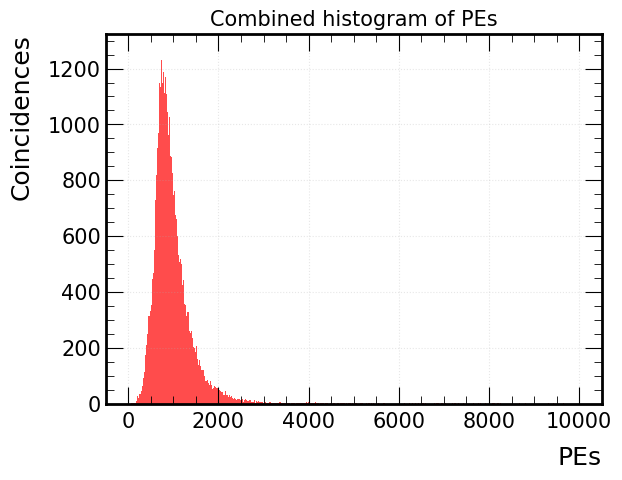

In [14]:
# Combine the histograms
combined_counts = np.zeros(nbins)

# Loop through the processed results and add the counts
for result in processed_hists:
    if result is not None:  # Check that the processing was successful
        counts, _ = result  # Unpack the counts and bin_edges
        # Convert awkward array to numpy array if needed
        if hasattr(counts, 'to_numpy'):
            counts = counts.to_numpy()
        elif not isinstance(counts, np.ndarray):
            counts = np.array(counts)
        # Now add to the combined histogram
        combined_counts += counts

# Create the bin centres for plotting
bin_centres = np.linspace(
    xrange[0] + (xrange[1] - xrange[0])/(2*nbins),
    xrange[1] - (xrange[1] - xrange[0])/(2*nbins),
    nbins
)

# Plot the combined histogram
plt.style.use("mu2e.mplstyle") 
plt.figure()
plt.bar(bin_centres, combined_counts, width=(xrange[1] - xrange[0])/nbins, alpha=0.7)
plt.xlabel('PEs')
plt.ylabel('Coincidences')
plt.title('Combined histogram of PEs')
plt.grid(True, alpha=0.3)
plt.show()
        

> **Note**: I am not using `pyplot` here because at present it only works with flattened arrays, not histogram objects.